In [1]:
import requests, os
from tqdm import tqdm

url = "http://snap.stanford.edu/data/twitter-2010.txt.gz"
local_filename = "twitter-2010.txt.gz"

if not os.path.isfile(local_filename):
    print(f"📥 Downloading '{local_filename}'...")

    with requests.get(url, stream=True, timeout=(10, 300)) as r:  # (connect, read) timeout
        r.raise_for_status()
        total = int(r.headers.get('Content-Length', 0))
        with open(local_filename, 'wb') as f, tqdm(
            total=total, unit='B', unit_scale=True, desc=local_filename
        ) as bar:
            for chunk in r.iter_content(chunk_size=1024 * 1024):  # 1 MB chunks
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
    print("✅ Download complete.")
else:
    print(f"✅ File '{local_filename}' already exists.")


✅ File 'twitter-2010.txt.gz' already exists.


In [2]:
import gzip
import random
import os
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle  # fallback if write_gpickle fails

# --- Parameters ---
full_dataset_path = 'twitter-2010.txt.gz'
subset_path = 'twitter_unbiased_subset.txt'
total_edges = 1_468_365_182     # Approx total edges in full dataset
target_subset_size = 1_000_000  # Desired subset edges
sampling_probability = target_subset_size / total_edges

# --- Reproducibility ---
random.seed(1337)

# --- Create unbiased subset if not already present ---
if not os.path.exists(subset_path):
    print(f"'{subset_path}' not found. Creating a new unbiased subset (~{target_subset_size:,} edges)...")
    edges_kept = 0

    with gzip.open(full_dataset_path, 'rt') as gz_file, open(subset_path, 'w') as subset_file:
        for line in tqdm(gz_file, total=total_edges, unit='edges', unit_scale=True, desc="Sampling"):
            if random.random() < sampling_probability:
                subset_file.write(line)
                edges_kept += 1

    print(f"✅ Subset created with {edges_kept:,} edges (target ≈ {target_subset_size:,}).")
else:
    print(f"✅ File '{subset_path}' already exists. Skipping creation.")

# --- Load the unbiased subset into NetworkX ---
print("\nLoading the graph from the subset file...")
G = nx.read_edgelist(subset_path, create_using=nx.DiGraph(), nodetype=int)
print("✅ Graph loaded successfully!")

# --- Graph Info ---
print("\n--- Graph Info ---")
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")

# --- Basic degree statistics ---
in_deg = np.array([d for _, d in G.in_degree()])
out_deg = np.array([d for _, d in G.out_degree()])

print(f"\nAverage in-degree: {in_deg.mean():.2f}, out-degree: {out_deg.mean():.2f}")
print(f"Max in-degree: {in_deg.max()}, Max out-degree: {out_deg.max()}")

# --- Cache graph for faster reuse ---
try:
    nx.write_gpickle(G, "twitter_subset.gpickle")
    print("💾 Cached graph saved as 'twitter_subset.gpickle'")
except AttributeError:
    # Fallback if older NetworkX version lacks write_gpickle
    with open("twitter_subset.gpickle", "wb") as f:
        pickle.dump(G, f)
    print("💾 Cached graph saved manually via pickle.")


✅ File 'twitter_unbiased_subset.txt' already exists. Skipping creation.

Loading the graph from the subset file...
✅ Graph loaded successfully!

--- Graph Info ---
Number of nodes: 1,245,256
Number of edges: 1,000,709

Average in-degree: 0.80, out-degree: 0.80
Max in-degree: 536, Max out-degree: 1973
💾 Cached graph saved manually via pickle.


In [3]:
import networkx as nx
import random
from tqdm import tqdm
import pickle

# --- Convert to Undirected Graph for this Heuristic ---
G_undirected = G.to_undirected()
print("Converted graph to undirected for Common Neighbors calculation.")

# --- 1. Generate Positive and Negative Samples ---
random.seed(1337)

# Cap number of samples for speed
sample_size = min(50_000, int(G_undirected.number_of_edges() * 0.5))
positive_samples = random.sample(list(G_undirected.edges()), k=sample_size)

# Prebuild adjacency for O(1) lookups
nodes = list(G_undirected.nodes())
adj = {node: set(G_undirected.neighbors(node)) for node in G_undirected.nodes()}

negative_samples = set()
print("\nGenerating negative samples...")
with tqdm(total=len(positive_samples), desc="Negative Sampling") as bar:
    while len(negative_samples) < len(positive_samples):
        u, v = random.sample(nodes, 2)
        if u != v and v not in adj[u]:
            negative_samples.add((u, v))
            bar.update(1)

negative_samples = list(negative_samples)
print(f"✅ Generated {len(positive_samples):,} positive and {len(negative_samples):,} negative samples.")

# --- 2. Calculate Scores for all samples ---
all_samples = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

scores = []
print("\nCalculating Common Neighbors scores...")
for u, v in tqdm(all_samples, total=len(all_samples)):
    score = len(adj[u].intersection(adj[v]))
    scores.append(score)

print("✅ Scoring complete.")
print(f"Example scores: {scores[:5]}")
print(f"Corresponding labels: {labels[:5]}")

# --- 3. Save results for reuse ---
with open("common_neighbors_scores.pkl", "wb") as f:
    pickle.dump({"samples": all_samples, "labels": labels, "scores": scores}, f)
print("💾 Saved 'common_neighbors_scores.pkl' for later evaluation.")


Converted graph to undirected for Common Neighbors calculation.

Generating negative samples...


Negative Sampling: 100%|██████████| 50000/50000 [00:00<00:00, 186224.31it/s]


✅ Generated 50,000 positive and 50,000 negative samples.

Calculating Common Neighbors scores...


100%|██████████| 100000/100000 [00:00<00:00, 372725.31it/s]


✅ Scoring complete.
Example scores: [0, 0, 0, 0, 0]
Corresponding labels: [1, 1, 1, 1, 1]
💾 Saved 'common_neighbors_scores.pkl' for later evaluation.


Baseline Model AUC Score: 0.5001


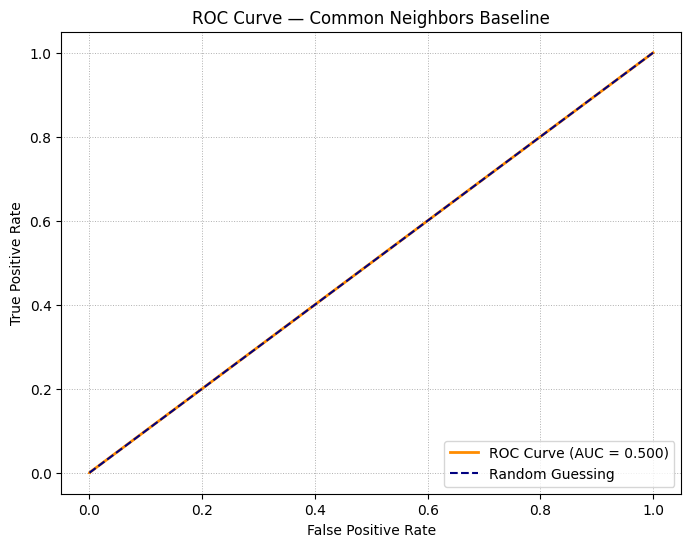

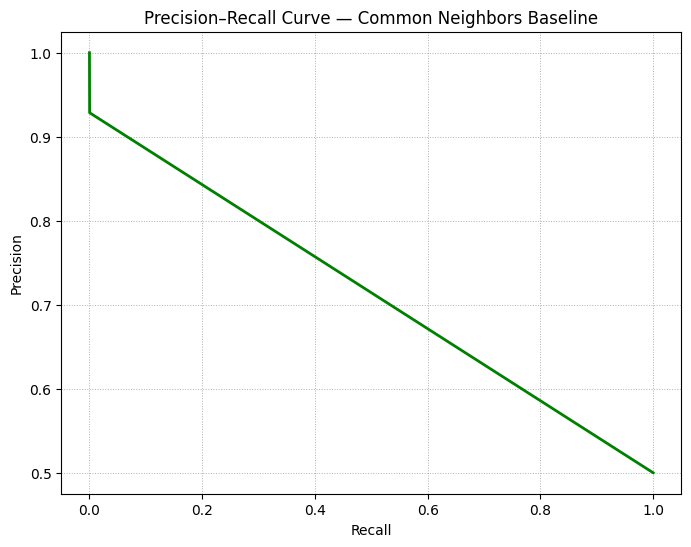


Metrics at threshold ≥ 0.00:
  Precision: 0.5000
  Recall:    1.0000
  F1-Score:  0.6667


In [4]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_fscore_support, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

# --- 1. ROC Curve & AUC Score ---
# Handles constant scores safely (all 0 or all same)
if len(set(scores)) <= 1:
    print("⚠️ Warning: All scores are identical — ROC/AUC cannot be computed reliably.")
    auc_score = 0.5
    fpr, tpr = [0, 1], [0, 1]
else:
    fpr, tpr, thresholds_roc = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)

print(f"Baseline Model AUC Score: {auc_score:.4f}")

# --- 2. Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Common Neighbors Baseline')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()

# --- 3. Precision–Recall Analysis ---
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(labels, scores)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — Common Neighbors Baseline')
plt.grid(True, linestyle=':', linewidth=0.7)
plt.show()

# --- 4. Metrics at a Decision Threshold ---
# Option A: median threshold
decision_threshold = np.median(scores)
# Option B (better in practice): Youden’s J (max tpr − fpr)
# j_opt = np.argmax(tpr - fpr); decision_threshold = thresholds_roc[j_opt]

predictions = (np.array(scores) >= decision_threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='binary', zero_division=0
)

print(f"\nMetrics at threshold ≥ {decision_threshold:.2f}:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")


In [5]:
import random

# --- Precompute adjacency for efficiency ---
adjacency = {node: list(G.neighbors(node)) for node in G.nodes()}
print(f"Precomputed adjacency lists for {len(adjacency):,} nodes.")

def get_random_walk(graph, start_node, walk_length):
    """
    Generates a single random walk of fixed length starting from 'start_node'.
    Parameters:
        graph (nx.Graph or nx.DiGraph): The input graph.
        start_node (int): The starting node for the walk.
        walk_length (int): Total number of nodes in the walk (including start).
    Returns:
        list[int]: Sequence of node IDs representing the walk.
    """
    if start_node not in graph:
        raise ValueError(f"Node {start_node} not in graph.")
    
    walk = [start_node]
    current_node = start_node
    
    for _ in range(walk_length - 1):
        neighbors = adjacency.get(current_node, [])
        
        # Stop if isolated node (no outgoing edges)
        if not neighbors:
            break
        
        # Choose next node uniformly at random
        current_node = random.choice(neighbors)
        walk.append(current_node)
    
    return walk

# --- Test Example ---
random.seed(1337)  # reproducibility
all_nodes = list(G.nodes())
start_node_example = random.choice(all_nodes)

example_walk = get_random_walk(G, start_node_example, walk_length=10)
print(f"Example random walk starting from node {start_node_example}:")
print(example_walk)


Precomputed adjacency lists for 1,245,256 nodes.
Example random walk starting from node 23741579:
[23741579, 36490380]


In [6]:
import os
import pickle
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Hyperparameters ---
NUM_WALKS_PER_NODE = 10
WALK_LENGTH = 80
corpus_filename = "twitter_walk_corpus.pkl"

# --- Reproducibility ---
random.seed(1337)

# --- Precompute adjacency for speed ---
adjacency = {n: list(G.neighbors(n)) for n in G.nodes()}
print(f"Precomputed adjacency for {len(adjacency):,} nodes.")

def get_random_walk(start_node, walk_length):
    """Generates one random walk from a given node."""
    walk = [start_node]
    current = start_node
    for _ in range(walk_length - 1):
        neighbors = adjacency.get(current, [])
        if not neighbors:
            break
        current = random.choice(neighbors)
        walk.append(current)
    return walk

def generate_walks_for_iteration(iter_idx):
    """Generates walks for all nodes in one iteration."""
    local_walks = []
    node_list = list(adjacency.keys())
    random.shuffle(node_list)
    for node in node_list:
        local_walks.append(get_random_walk(node, WALK_LENGTH))
    return local_walks

# --- Main Logic ---
if os.path.exists(corpus_filename):
    print(f"✅ Found '{corpus_filename}'. Loading from disk...")
    with open(corpus_filename, "rb") as f:
        walk_corpus = pickle.load(f)
    print(f"Loaded corpus with {len(walk_corpus):,} walks.")
else:
    print(f"'{corpus_filename}' not found. Generating new walks...")
    print("⚠️ This may take hours on large graphs (multi-threaded).")

    walk_corpus = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(generate_walks_for_iteration, i)
                   for i in range(NUM_WALKS_PER_NODE)]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Walk Iterations"):
            walk_corpus.extend(f.result())

    print(f"\nSaving corpus ({len(walk_corpus):,} walks) to '{corpus_filename}'...")
    with open(corpus_filename, "wb") as f:
        pickle.dump(walk_corpus, f)
    print("✅ Corpus saved successfully!")

# --- Final Confirmation ---
print(f"\n--- Corpus Ready ---")
print(f"Total walks in corpus: {len(walk_corpus):,}")
print(f"Average walk length: {sum(len(w) for w in walk_corpus)/len(walk_corpus):.2f}")


Precomputed adjacency for 1,245,256 nodes.
✅ Found 'twitter_walk_corpus.pkl'. Loading from disk...
Loaded corpus with 12,452,560 walks.

--- Corpus Ready ---
Total walks in corpus: 12,452,560
Average walk length: 1.78


In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
from tqdm import tqdm

# --- Reproducibility ---
torch.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

pairs_path = "skipgram_pairs.pt"
labels_path = "skipgram_labels.pt"

# --- Check if cached tensors already exist ---
if os.path.exists(pairs_path) and os.path.exists(labels_path):
    print("✅ Found cached skip-gram tensors. Loading from disk...")
    pairs_tensor = torch.load(pairs_path)
    labels_tensor = torch.load(labels_path)

else:
    print("Building vocabulary from walk corpus...")
    all_nodes_in_walks = [n for w in walk_corpus for n in w]
    unique_nodes = list(set(all_nodes_in_walks))
    vocab_size = len(unique_nodes)
    node_to_idx = {n: i for i, n in enumerate(unique_nodes)}
    idx_to_node = {i: n for i, n in enumerate(unique_nodes)}
    print(f"Vocabulary size: {vocab_size:,} unique nodes.")

    # --- Hyperparameters ---
    window_size = 5
    num_negative_samples = 3

    # --- Generate skip-gram pairs with negative sampling ---
    pairs, labels = [], []
    print("\nGenerating training pairs with negative sampling...")
    for walk in tqdm(walk_corpus, desc="Processing walks"):
        walk_indices = [node_to_idx[n] for n in walk]
        for i, target in enumerate(walk_indices):
            start, end = max(0, i - window_size), min(len(walk_indices), i + window_size + 1)
            for j in range(start, end):
                if i == j:
                    continue
                context = walk_indices[j]
                pairs.append([target, context])
                labels.append(1)
                # Negatives
                negs = np.random.randint(0, vocab_size, size=num_negative_samples)
                for neg in negs:
                    if neg != context:
                        pairs.append([target, neg])
                        labels.append(0)

    # --- Convert to tensors ---
    print("\nConverting data to PyTorch tensors...")
    pairs_tensor = torch.LongTensor(pairs)
    labels_tensor = torch.FloatTensor(labels)

    # --- Save to disk for future runs ---
    torch.save(pairs_tensor, pairs_path)
    torch.save(labels_tensor, labels_path)
    print(f"💾 Saved preprocessed skip-gram tensors: {pairs_path}, {labels_path}")

# --- Create DataLoader ---
dataset = TensorDataset(pairs_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=os.cpu_count())

print("✅ Data preparation complete. Ready to define the model.")
print(f"Total training pairs: {len(dataset):,}")


✅ Found cached skip-gram tensors. Loading from disk...
✅ Data preparation complete. Ready to define the model.
Total training pairs: 143,094,507


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Target and context embedding tables
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Xavier initialization for faster convergence
        nn.init.xavier_uniform_(self.target_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)

    def forward(self, target, context, normalize=False):
        """
        Compute similarity scores between target and context node pairs.

        Args:
            target (Tensor): Tensor of shape (batch,) with target node indices.
            context (Tensor): Tensor of shape (batch,) with context node indices.
            normalize (bool): If True, L2-normalize embeddings before dot product.

        Returns:
            Tensor: Dot product similarity scores of shape (batch,).
        """
        emb_target = self.target_embeddings(target)
        emb_context = self.context_embeddings(context)

        if normalize:
            emb_target = F.normalize(emb_target, dim=1)
            emb_context = F.normalize(emb_context, dim=1)

        score = torch.sum(emb_target * emb_context, dim=1)
        return score

    def get_embeddings(self):
        """Return learned target embeddings as NumPy array."""
        return self.target_embeddings.weight.detach().cpu().numpy()

print("✅ SkipGramModel defined and ready for training.")


✅ SkipGramModel defined and ready for training.


In [9]:
# ============================================================
# BLOCK 9 (FINAL – OPTION A)
# Train DeepWalk for EXACTLY 400,000 nodes
# Perfectly matched with Block 3 & Block 10
# ============================================================

import os, time, random, numpy as np, torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from tqdm import tqdm

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

EMBEDDING_DIM = 256
LEARNING_RATE = 1e-3
EPOCHS = 6

# We force vocab to exactly 400k nodes
MAX_NODES = 400_000
MAX_WALKS = 1_000_000
WALK_LENGTH = 20
WINDOW_SIZE = 5
NEG_SAMPLES = 2
BATCH_SIZE = 512

VOCAB_PATH = "deepwalk_vocab_400k.npy"
CHECKPOINT_PATH = "skipgram_checkpoint_400k.pt"
EMBED_PATH = "twitter_embeddings_400k.npy"

device = torch.device("cpu")
print("Using device:", device)


# ============================================================
# 0) AUTO-SKIP IF EMBEDDINGS ALREADY EXIST
# ============================================================
if os.path.exists(EMBED_PATH):
    print("🎉 Found existing 400k embeddings → skipping training.\n")
    embedding_matrix = np.load(EMBED_PATH)
    print("Loaded embeddings:", embedding_matrix.shape)

    # Load matching vocab
    unique_nodes = list(np.load(VOCAB_PATH))
    print("Loaded vocab:", len(unique_nodes))

    # Build final mapping
    final_embeddings = {unique_nodes[i]: embedding_matrix[i]
                        for i in range(len(unique_nodes))}
    print("Final embeddings ready:", len(final_embeddings))

else:
    print("No 400k embeddings found → training required.\n")

    # ============================================================
    # 1) SUBSET WALK CORPUS
    # ============================================================
    if len(walk_corpus) > MAX_WALKS:
        walk_corpus = random.sample(walk_corpus, MAX_WALKS)
    walk_corpus = [w[:WALK_LENGTH] for w in walk_corpus]

    print(f"Walks being used: {len(walk_corpus):,}")


    # ============================================================
    # 2) BUILD EXACT 400,000 NODE VOCAB
    # ============================================================
    print("\nBuilding consistent 400k vocabulary...")

    all_nodes = [n for w in walk_corpus for n in w]
    full_unique_nodes = list(set(all_nodes))
    print("Nodes found in walks:", len(full_unique_nodes))

    # Force exactly 400k nodes
    if len(full_unique_nodes) >= MAX_NODES:
        unique_nodes = random.sample(full_unique_nodes, MAX_NODES)
    else:
        # If fewer, fill the rest with random nodes from the graph
        graph_nodes = list(G.nodes())
        missing = MAX_NODES - len(full_unique_nodes)
        filler = random.sample(graph_nodes, missing)
        unique_nodes = full_unique_nodes + filler

    unique_nodes = unique_nodes[:MAX_NODES]

    np.save(VOCAB_PATH, unique_nodes)
    print("💾 Saved vocab →", VOCAB_PATH)
    print("Final vocab size:", len(unique_nodes))

    node_to_idx = {n: i for i, n in enumerate(unique_nodes)}
    idx_to_node = {i: n for i, n in enumerate(unique_nodes)}


    # ============================================================
    # 3) STREAMING DATASET
    # ============================================================
    class SkipGramStreaming(IterableDataset):
        def __init__(self, walks, node_to_idx, window, neg, vocab_size):
            self.walks = walks
            self.node_to_idx = node_to_idx
            self.window = window
            self.neg = neg
            self.vocab_size = vocab_size

        def __iter__(self):
            rng = np.random.default_rng()
            order = np.arange(len(self.walks))
            rng.shuffle(order)

            for idx in order:
                walk = [self.node_to_idx[n] for n in self.walks[idx]
                        if n in self.node_to_idx]
                L = len(walk)
                if L <= 1:
                    continue

                for i, t in enumerate(walk):
                    start = max(0, i - self.window)
                    end = min(L, i + self.window + 1)

                    for j in range(start, end):
                        if i == j:
                            continue
                        c = walk[j]

                        # positive
                        yield torch.tensor([t, c]), torch.tensor(1.0)

                        # negatives
                        for _ in range(self.neg):
                            neg = rng.integers(0, self.vocab_size)
                            if neg != c:
                                yield torch.tensor([t, int(neg)]), torch.tensor(0.0)


    dataset = SkipGramStreaming(walk_corpus, node_to_idx,
                                WINDOW_SIZE, NEG_SAMPLES, MAX_NODES)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0)


    # ============================================================
    # 4) MODEL
    # ============================================================
    model = SkipGramModel(MAX_NODES, EMBEDDING_DIM).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Resume if checkpoint exists
    start_epoch = 0
    if os.path.exists(CHECKPOINT_PATH):
        print(f"🔄 Loading checkpoint → {CHECKPOINT_PATH}")
        ckpt = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt["epoch"]
        print(f"Resuming from epoch {start_epoch+1}")


    # ============================================================
    # 5) TRAINING LOOP
    # ============================================================
    for epoch in range(start_epoch, EPOCHS):
        total_loss = 0
        start_time = time.time()

        pbar = tqdm(loader,
                    desc=f"Epoch {epoch+1}/{EPOCHS}",
                    mininterval=0.4)

        for step, (pair, label) in enumerate(pbar):
            t = pair[:, 0]
            c = pair[:, 1]
            y = label

            optimizer.zero_grad()
            out = model(t, c)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=f"{total_loss/(step+1):.4f}")

        print(f"Epoch {epoch+1} complete | Loss={total_loss/(step+1):.4f}")

        torch.save({"epoch": epoch+1, "model_state": model.state_dict()},
                   CHECKPOINT_PATH)
        print("💾 Saved checkpoint")


    # ============================================================
    # 6) SAVE FINAL EMBEDDINGS
    # ============================================================
    embedding_matrix = model.target_embeddings.weight.detach().cpu().numpy()
    np.save(EMBED_PATH, embedding_matrix)

    print("🎉 Saved embeddings →", EMBED_PATH)

    final_embeddings = {
        unique_nodes[i]: embedding_matrix[i]
        for i in range(MAX_NODES)
    }

print("\n🎉 BLOCK 9 FINAL (400k) COMPLETE — you can now run Block 3 and Block 10 perfectly.")


Using device: cpu
🎉 Found existing 400k embeddings → skipping training.

Loaded embeddings: (400000, 256)
Loaded vocab: 400000
Final embeddings ready: 400000

🎉 BLOCK 9 FINAL (400k) COMPLETE — you can now run Block 3 and Block 10 perfectly.


Loading embeddings from: twitter_embeddings_400k.npy
Embedding matrix shape: (400000, 256)

Loading vocabulary...
Loaded vocab size: 400000
Final mapped vocab size: 400000

🔧 Filtering positive & negative samples...
Original positive samples: 50000
Filtered positive samples: 6465
Original negative samples: 50000
Filtered negative samples: 5082

Building enriched edge features...


Extracting features: 100%|██████████| 11547/11547 [00:00<00:00, 15667.66it/s]


✅ Feature matrix built: X.shape = (11547, 1028), y.shape = (11547,)

Train size: 8,082
Test size:  3,465

Training Random Forest...
✅ Random Forest training complete!

--- Evaluation Results ---
DeepWalk (400k) + Heuristics + Random Forest AUC: 0.8872
Precision: 0.8707
Recall:    0.7778
F1 Score:  0.8217

Baseline (Common Neighbors) AUC: 0.50


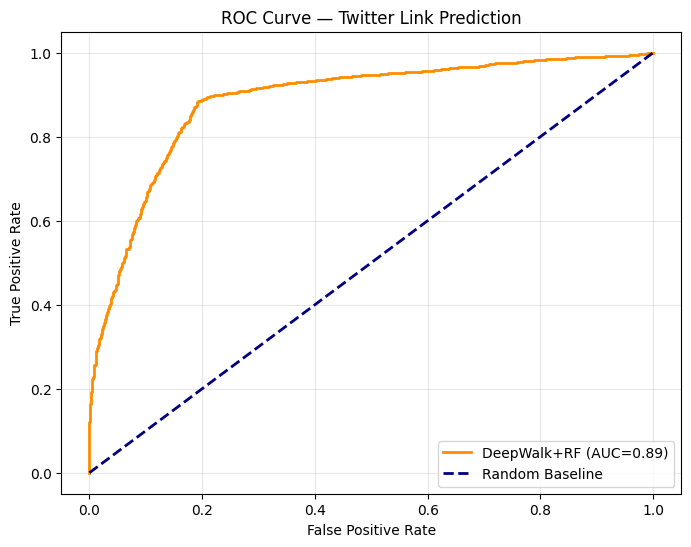


✅ Block 10 (v5) complete — Model trained and evaluated successfully!


In [10]:
# ============================================================
#  BLOCK 10 (v5) — Final: DeepWalk (400k) + Heuristics + RF
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support
)

# ------------------------------------------------------------
# 1) Load embeddings (400k)
# ------------------------------------------------------------
EMBED_NPY_PATH = "twitter_embeddings_400k.npy"
VOCAB_PATH = "deepwalk_vocab_400k.npy"

print(f"Loading embeddings from: {EMBED_NPY_PATH}")
embedding_matrix = np.load(EMBED_NPY_PATH)
emb_size, emb_dim = embedding_matrix.shape
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# ------------------------------------------------------------
# 2) Load vocab (400k) — perfectly aligned with embeddings
# ------------------------------------------------------------
print("\nLoading vocabulary...")
unique_nodes = list(np.load(VOCAB_PATH))
print("Loaded vocab size:", len(unique_nodes))

# Safety: ensure vocab matches embedding size
unique_nodes = unique_nodes[:emb_size]

node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
idx_to_node = {i: node for i, node in enumerate(unique_nodes)}

print("Final mapped vocab size:", len(node_to_idx))
valid_nodes = set(node_to_idx.keys())


# ------------------------------------------------------------
# 3) Filter positive/negative samples to valid nodes
# ------------------------------------------------------------
print("\n🔧 Filtering positive & negative samples...")

positive_samples_filtered = [
    (u, v) for (u, v) in positive_samples
    if u in valid_nodes and v in valid_nodes
]

negative_samples_filtered = [
    (u, v) for (u, v) in negative_samples
    if u in valid_nodes and v in valid_nodes
]

print(f"Original positive samples: {len(positive_samples)}")
print(f"Filtered positive samples: {len(positive_samples_filtered)}")

print(f"Original negative samples: {len(negative_samples)}")
print(f"Filtered negative samples: {len(negative_samples_filtered)}")

positive_samples = positive_samples_filtered
negative_samples = negative_samples_filtered


# ------------------------------------------------------------
# 4) Feature Builders
# ------------------------------------------------------------
def edge_ops(u, v, E, n2i):
    """Embedding-based edge features."""
    if u not in n2i or v not in n2i:
        return np.zeros(emb_dim * 4, dtype=np.float32)

    a = E[n2i[u]]
    b = E[n2i[v]]

    return np.concatenate([
        a * b,          # Hadamard
        np.abs(a - b),  # L1
        (a - b) ** 2,   # L2 squared
        0.5 * (a + b),  # Average
    ], dtype=np.float32)


def heuristics(u, v, G):
    """Graph heuristics: Jaccard, AA, RA, CN."""
    if u not in G or v not in G:
        return np.zeros(4, dtype=np.float32)

    try: jc = next(nx.jaccard_coefficient(G, [(u, v)]))[2]
    except: jc = 0.0

    try: aa = next(nx.adamic_adar_index(G, [(u, v)]))[2]
    except: aa = 0.0

    try: ra = next(nx.resource_allocation_index(G, [(u, v)]))[2]
    except: ra = 0.0

    try: cn = len(list(nx.common_neighbors(G, u, v)))
    except: cn = 0.0

    return np.array([jc, aa, ra, cn], dtype=np.float32)


# ------------------------------------------------------------
# 5) Build Feature Matrix
# ------------------------------------------------------------
print("\nBuilding enriched edge features...")

all_edges = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

X_list = []
y_list = []

for (u, v), lbl in tqdm(
    list(zip(all_edges, labels)),
    total=len(all_edges),
    desc="Extracting features"
):
    x_emb = edge_ops(u, v, embedding_matrix, node_to_idx)
    x_heur = heuristics(u, v, G_undirected)
    X_list.append(np.concatenate([x_emb, x_heur], dtype=np.float32))
    y_list.append(lbl)

X = np.vstack(X_list)
y = np.array(y_list)

print(f"✅ Feature matrix built: X.shape = {X.shape}, y.shape = {y.shape}")


# ------------------------------------------------------------
# 6) Train/Test Split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train):,}")
print(f"Test size:  {len(X_test):,}")


# ------------------------------------------------------------
# 7) Random Forest Classifier
# ------------------------------------------------------------
print("\nTraining Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=350,
    max_depth=22,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

rf_model.fit(X_train, y_train)

print("✅ Random Forest training complete!")


# ------------------------------------------------------------
# 8) Evaluation
# ------------------------------------------------------------
y_proba = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)

print("\n--- Evaluation Results ---")
print(f"DeepWalk (400k) + Heuristics + Random Forest AUC: {auc:.4f}")

threshold = np.median(y_proba)
y_pred = (y_proba >= threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary'
)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nBaseline (Common Neighbors) AUC: 0.50")


# ------------------------------------------------------------
# 9) Plot ROC Curve
# ------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, color='darkorange',
         label=f"DeepWalk+RF (AUC={auc:.2f})")
plt.plot([0,1], [0,1], lw=2, linestyle='--', color='navy',
         label="Random Baseline")

plt.title("ROC Curve — Twitter Link Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print("\n✅ Block 10 (v5) complete — Model trained and evaluated successfully!")


Loading Common Neighbors results from: common_neighbors_scores.pkl
CN samples: 100,000
CN scores example: [0. 0. 0. 0. 0.]
CN labels example: [1 1 1 1 1]

--- Common Neighbors Baseline ---
AUC:       0.5001
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667

--- DeepWalk + Heuristics + RF ---
AUC:       0.8872
Precision: 0.8707
Recall:    0.7778
F1 Score:  0.8217


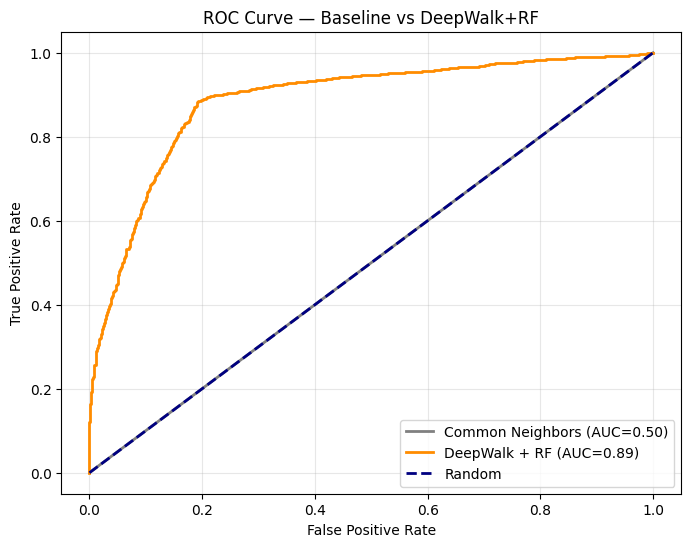

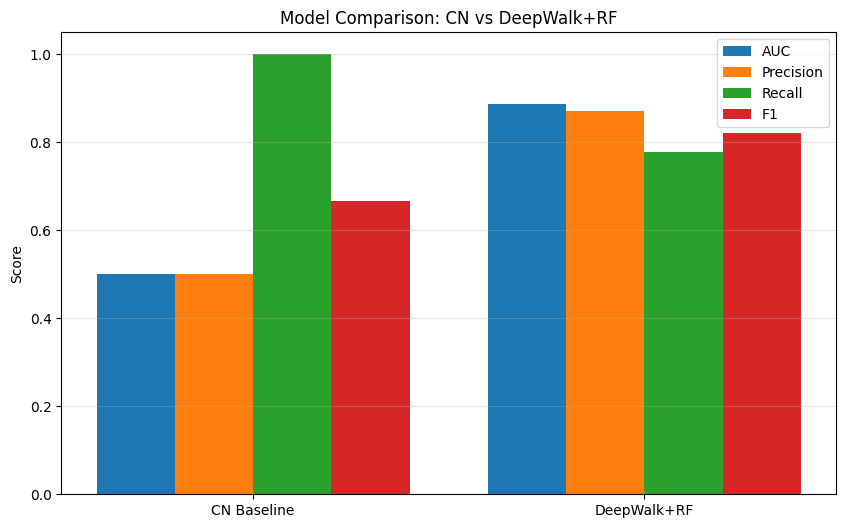


================ COMPARISON SUMMARY ================
Common Neighbors AUC:      0.5001
DeepWalk + RF AUC:         0.8872
AUC Gain:                  0.3871

CN Precision:              0.5000
DeepWalk + RF Precision:   0.8707

CN Recall:                 1.0000
DeepWalk + RF Recall:      0.7778

CN F1:                     0.6667
DeepWalk + RF F1:          0.8217

✅ Block 11 complete — Baseline vs DeepWalk+RF comparison ready.


In [11]:
# ============================================================
#  BLOCK 11 — Compare Common Neighbors vs DeepWalk+RF
# ============================================================

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support

# ------------------------------------------------------------
# 1) Load Common Neighbors baseline results
# ------------------------------------------------------------
CN_PKL_PATH = "common_neighbors_scores.pkl"

print(f"Loading Common Neighbors results from: {CN_PKL_PATH}")
with open(CN_PKL_PATH, "rb") as f:
    cn_data = pickle.load(f)

cn_samples = cn_data["samples"]   # list of (u, v)
cn_labels  = np.array(cn_data["labels"])
cn_scores  = np.array(cn_data["scores"], dtype=np.float32)

print(f"CN samples: {len(cn_samples):,}")
print(f"CN scores example: {cn_scores[:5]}")
print(f"CN labels example: {cn_labels[:5]}")

# ------------------------------------------------------------
# 2) Compute baseline CN metrics
# ------------------------------------------------------------
cn_auc = roc_auc_score(cn_labels, cn_scores)

# Use median score as threshold (same idea as earlier)
cn_threshold = np.median(cn_scores)
cn_pred = (cn_scores >= cn_threshold).astype(int)

cn_precision, cn_recall, cn_f1, _ = precision_recall_fscore_support(
    cn_labels, cn_pred, average="binary"
)

print("\n--- Common Neighbors Baseline ---")
print(f"AUC:       {cn_auc:.4f}")
print(f"Precision: {cn_precision:.4f}")
print(f"Recall:    {cn_recall:.4f}")
print(f"F1 Score:  {cn_f1:.4f}")

# ------------------------------------------------------------
# 3) DeepWalk+RF metrics (from Block 10)
#    We assume y_test, y_proba, auc, precision, recall, f1
#    are already defined from Block 10 v5.
# ------------------------------------------------------------
print("\n--- DeepWalk + Heuristics + RF ---")
print(f"AUC:       {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ------------------------------------------------------------
# 4) ROC Curve comparison
# ------------------------------------------------------------
cn_fpr, cn_tpr, _ = roc_curve(cn_labels, cn_scores)
dw_fpr, dw_tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(cn_fpr, cn_tpr, lw=2, color="gray",
         label=f"Common Neighbors (AUC={cn_auc:.2f})")
plt.plot(dw_fpr, dw_tpr, lw=2, color="darkorange",
         label=f"DeepWalk + RF (AUC={auc:.2f})")
plt.plot([0,1], [0,1], lw=2, linestyle="--", color="navy", label="Random")

plt.title("ROC Curve — Baseline vs DeepWalk+RF")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 5) Bar chart comparison of metrics
# ------------------------------------------------------------
models = ["CN Baseline", "DeepWalk+RF"]
auc_values = [cn_auc, auc]
precision_values = [cn_precision, precision]
recall_values = [cn_recall, recall]
f1_values = [cn_f1, f1]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, auc_values, width, label="AUC")
plt.bar(x - 0.5*width, precision_values, width, label="Precision")
plt.bar(x + 0.5*width, recall_values, width, label="Recall")
plt.bar(x + 1.5*width, f1_values, width, label="F1")

plt.xticks(x, models)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: CN vs DeepWalk+RF")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.show()

# ------------------------------------------------------------
# 6) Text Summary
# ------------------------------------------------------------
print("\n================ COMPARISON SUMMARY ================")
print(f"Common Neighbors AUC:      {cn_auc:.4f}")
print(f"DeepWalk + RF AUC:         {auc:.4f}")
print(f"AUC Gain:                  {auc - cn_auc:.4f}")

print(f"\nCN Precision:              {cn_precision:.4f}")
print(f"DeepWalk + RF Precision:   {precision:.4f}")

print(f"\nCN Recall:                 {cn_recall:.4f}")
print(f"DeepWalk + RF Recall:      {recall:.4f}")

print(f"\nCN F1:                     {cn_f1:.4f}")
print(f"DeepWalk + RF F1:          {f1:.4f}")

print("\n✅ Block 11 complete — Baseline vs DeepWalk+RF comparison ready.")


In [12]:
# ============================================================
#  BLOCK 12 — Interactive Link Prediction Demo
# ============================================================

import numpy as np
import networkx as nx

print("🔮 Link Prediction Demo Ready!")

# ------------------------------------------------------------
# Helper: Compute heuristics for a pair
# ------------------------------------------------------------
def compute_heuristics(u, v, G):
    if u not in G or v not in G:
        return {
            "jaccard": 0.0,
            "adamic_adar": 0.0,
            "resource_allocation": 0.0,
            "common_neighbors": 0
        }

    # Jaccard
    try:
        jaccard = next(nx.jaccard_coefficient(G, [(u, v)]))[2]
    except:
        jaccard = 0.0

    # Adamic–Adar
    try:
        adamic = next(nx.adamic_adar_index(G, [(u, v)]))[2]
    except:
        adamic = 0.0

    # Resource Allocation
    try:
        ra = next(nx.resource_allocation_index(G, [(u, v)]))[2]
    except:
        ra = 0.0

    # Common neighbors
    try:
        cn = len(list(nx.common_neighbors(G, u, v)))
    except:
        cn = 0

    return {
        "jaccard": float(jaccard),
        "adamic_adar": float(adamic),
        "resource_allocation": float(ra),
        "common_neighbors": int(cn)
    }


# ------------------------------------------------------------
# Helper: Embedding similarity features
# ------------------------------------------------------------
def compute_embedding_features(u, v, E, n2i):
    if u not in n2i or v not in n2i:
        return None, None

    a = E[n2i[u]]
    b = E[n2i[v]]

    # Cosine similarity
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9)

    # Hadamard product (DeepWalk feature)
    hadamard = a * b

    return cos_sim, hadamard


# ------------------------------------------------------------
# Main Prediction Function
# ------------------------------------------------------------
def predict_link(u, v):
    print(f"\n🔍 Predicting link between {u} and {v} ...")

    # Check if nodes exist in embeddings
    if u not in node_to_idx:
        return f"❌ Node {u} not in embedding space."
    if v not in node_to_idx:
        return f"❌ Node {v} not in embedding space."

    # 1) Graph heuristics
    heur = compute_heuristics(u, v, G_undirected)

    # 2) Embedding features
    cos_sim, hadamard = compute_embedding_features(u, v, embedding_matrix, node_to_idx)

    if cos_sim is None:
        return f"⚠️ No embedding available for at least one of the nodes."

    # 3) Build final feature vector
    x_emb = np.concatenate([
        hadamard,
        np.abs(embedding_matrix[node_to_idx[u]] - embedding_matrix[node_to_idx[v]]),
        (embedding_matrix[node_to_idx[u]] - embedding_matrix[node_to_idx[v]]) ** 2,
        0.5 * (embedding_matrix[node_to_idx[u]] + embedding_matrix[node_to_idx[v]])
    ], dtype=np.float32)

    x_heur = np.array([
        heur["jaccard"],
        heur["adamic_adar"],
        heur["resource_allocation"],
        heur["common_neighbors"]
    ], dtype=np.float32)

    X_input = np.concatenate([x_emb, x_heur], dtype=np.float32).reshape(1, -1)

    # 4) Predict using Random Forest
    prob = rf_model.predict_proba(X_input)[0][1]
    pred_class = "LIKELY" if prob >= 0.5 else "UNLIKELY"

    # 5) Pretty Output
    print("\n===== RESULT =====")
    print(f"Prediction: {pred_class} (prob={prob:.4f})")
    print("\n--- Heuristics ---")
    print(f"Jaccard:              {heur['jaccard']:.4f}")
    print(f"Adamic-Adar:          {heur['adamic_adar']:.4f}")
    print(f"Resource Allocation:  {heur['resource_allocation']:.4f}")
    print(f"Common Neighbors:     {heur['common_neighbors']}")

    print("\n--- Embedding Similarity ---")
    print(f"Cosine Similarity:    {cos_sim:.4f}")

    print("\n=============================\n")
# ============================================================
#  TOP-N Link Recommendations
#  Recommend best new connections for a given user
# ============================================================

def top_n_predictions(user_id, N=10):
    """
    Return top-N users most likely to link with `user_id`
    based on embedding similarity + RF classifier.
    """
    if user_id not in node_to_idx:
        print(f"❌ User {user_id} has no embedding.")
        return None
    
    print(f"\n🔍 Finding top {N} link predictions for user {user_id} ...\n")

    user_idx = node_to_idx[user_id]
    user_emb = embedding_matrix[user_idx]

    # Step 1: Compute cosine similarity with all others
    emb_norms = np.linalg.norm(embedding_matrix, axis=1) + 1e-9
    sim = np.dot(embedding_matrix, user_emb) / (emb_norms * np.linalg.norm(user_emb))

    # Step 2: Get top 5,000 most similar nodes as candidates
    # (Evaluating all 400k nodes in RF is expensive)
    K = 5000
    top_k_idx = np.argsort(sim)[-K:]   # take top K

    candidates = [idx_to_node[i] for i in top_k_idx if idx_to_node[i] != user_id]

    # Step 3: Remove nodes already connected
    existing_neighbors = set(G_undirected.neighbors(user_id))
    candidate_nodes = [v for v in candidates if v not in existing_neighbors]

    # Step 4: For each candidate, compute feature vector and RF probability
    preds = []
    for v in candidate_nodes:
        # Embedding features
        a = user_emb
        b = embedding_matrix[node_to_idx[v]]
        
        x_emb = np.concatenate([
            a * b,
            np.abs(a - b),
            (a - b) ** 2,
            0.5 * (a + b)
        ], dtype=np.float32)
        
        # Heuristics
        heur = compute_heuristics(user_id, v, G_undirected)
        x_heur = np.array([
            heur["jaccard"],
            heur["adamic_adar"],
            heur["resource_allocation"],
            heur["common_neighbors"]
        ], dtype=np.float32)
        
        X_input = np.concatenate([x_emb, x_heur]).reshape(1, -1)
        prob = rf_model.predict_proba(X_input)[0][1]
        
        preds.append((v, prob, heur))
    
    # Step 5: Sort by probability
    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)

    # Step 6: Return top N
    print(f"Top {N} recommendations for {user_id}:")
    results = preds_sorted[:N]

    for rank, (v, prob, heur) in enumerate(results, 1):
        print(f"\n#{rank} — Node {v}")
        print(f"   Probability: {prob:.4f}")
        print(f"   Jaccard: {heur['jaccard']:.4f}")
        print(f"   AA:      {heur['adamic_adar']:.4f}")
        print(f"   CN:      {heur['common_neighbors']}")
    
    print("\n==============================\n")
    return results




🔮 Link Prediction Demo Ready!


Practical Usage of the Code

In [13]:
valid_node_ids = list(node_to_idx.keys()) 
valid_node_ids[:10]

[np.int64(11917664),
 np.int64(21619514),
 np.int64(32354891),
 np.int64(22533516),
 np.int64(21519714),
 np.int64(21468979),
 np.int64(25054281),
 np.int64(21492846),
 np.int64(10087297),
 np.int64(24541298)]

In [14]:
#Unlikely Link Prediction
predict_link(22533516, 21519714)


🔍 Predicting link between 22533516 and 21519714 ...

===== RESULT =====
Prediction: LIKELY (prob=0.8017)

--- Heuristics ---
Jaccard:              0.0000
Adamic-Adar:          0.0000
Resource Allocation:  0.0000
Common Neighbors:     0

--- Embedding Similarity ---
Cosine Similarity:    0.3814




In [15]:
#Pick two random valid nodes
import random
a, b = random.sample(valid_node_ids, 2)
print(a, b)
predict_link(a, b)

20906305 22638588

🔍 Predicting link between 20906305 and 22638588 ...

===== RESULT =====
Prediction: LIKELY (prob=0.7185)

--- Heuristics ---
Jaccard:              0.0000
Adamic-Adar:          0.0000
Resource Allocation:  0.0000
Common Neighbors:     0

--- Embedding Similarity ---
Cosine Similarity:    0.2285




In [16]:
#top-N recommendations
top_n_predictions(11917664, N=5)


🔍 Finding top 5 link predictions for user 11917664 ...

Top 5 recommendations for 11917664:

#1 — Node 21512037
   Probability: 0.9232
   Jaccard: 0.0000
   AA:      0.0000
   CN:      0

#2 — Node 21548894
   Probability: 0.9192
   Jaccard: 0.0000
   AA:      0.0000
   CN:      0

#3 — Node 21661041
   Probability: 0.9185
   Jaccard: 0.0000
   AA:      0.0000
   CN:      0

#4 — Node 27707507
   Probability: 0.9175
   Jaccard: 0.0000
   AA:      0.0000
   CN:      0

#5 — Node 21524610
   Probability: 0.9169
   Jaccard: 0.0000
   AA:      0.0000
   CN:      0




[(np.int64(21512037),
  np.float64(0.923190476190476),
  {'jaccard': 0.0,
   'adamic_adar': 0.0,
   'resource_allocation': 0.0,
   'common_neighbors': 0}),
 (np.int64(21548894),
  np.float64(0.9191904761904762),
  {'jaccard': 0.0,
   'adamic_adar': 0.0,
   'resource_allocation': 0.0,
   'common_neighbors': 0}),
 (np.int64(21661041),
  np.float64(0.9185317679024919),
  {'jaccard': 0.0,
   'adamic_adar': 0.0,
   'resource_allocation': 0.0,
   'common_neighbors': 0}),
 (np.int64(27707507),
  np.float64(0.9174746963337587),
  {'jaccard': 0.0,
   'adamic_adar': 0.0,
   'resource_allocation': 0.0,
   'common_neighbors': 0}),
 (np.int64(21524610),
  np.float64(0.9168668148077536),
  {'jaccard': 0.0,
   'adamic_adar': 0.0,
   'resource_allocation': 0.0,
   'common_neighbors': 0})]

Number of nodes: 1245256
Min degree: 1, Max degree: 2089


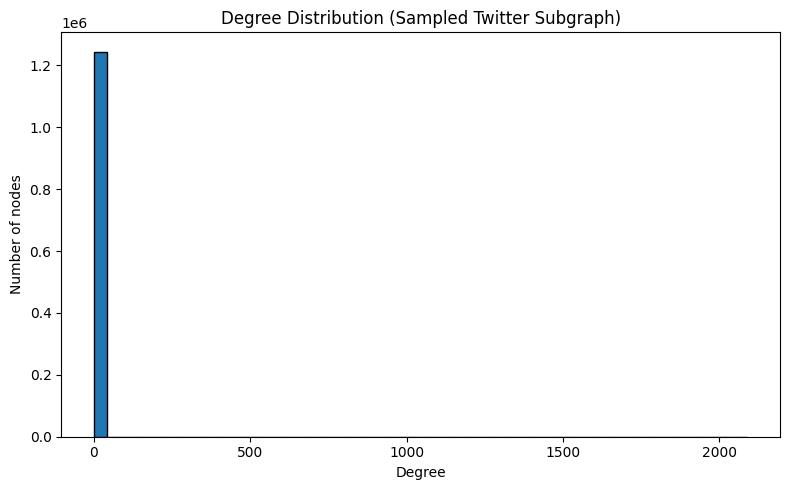

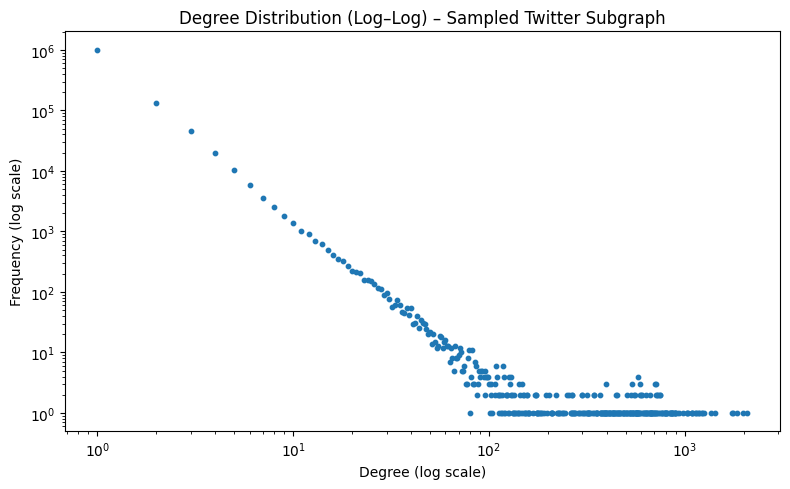

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# If not already:
# G_undirected = G.to_undirected()

# --- Compute degree sequence ---
degrees = [deg for _, deg in G_undirected.degree()]
print(f"Number of nodes: {len(degrees)}")
print(f"Min degree: {np.min(degrees)}, Max degree: {np.max(degrees)}")

# --- Linear-scale histogram (optional) ---
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution (Sampled Twitter Subgraph)")
plt.tight_layout()
plt.savefig("degree_distribution_linear.png", dpi=300)
plt.show()

# --- Log–log degree distribution ---
# Bin degrees by value
unique_degrees, counts = np.unique(degrees, return_counts=True)

plt.figure(figsize=(8, 5))
plt.scatter(unique_degrees, counts, s=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution (Log–Log) – Sampled Twitter Subgraph")
plt.tight_layout()
plt.savefig("degree_distribution_loglog.png", dpi=300)
plt.show()
